An example of how I would like to use MFDataset for reading in atmopsheric model. 

In [36]:
from __future__ import division

import matplotlib.pyplot as plt
import matplotlib as mpl
import netCDF4 as nc
import numpy as np

from salishsea_tools import (
    nc_tools,
    viz_tools,
    stormtools,
    tidetools,
)
import pytz, datetime
import glob
import os
import urllib2
import csv
import cStringIO
import requests
from xml.etree import cElementTree as ElementTree
import pandas as pd
import arrow
from matplotlib import dates


%matplotlib inline




In [3]:
grid = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
NEMOlat=grid.variables['nav_lat'][:]
NEMOlon=grid.variables['nav_lon'][:]
bathy=grid.variables['Bathymetry'][:]

In [4]:
GEM = nc.Dataset('/ocean/dlatorne/MEOPAR/GEM2.5/NEMO-atmos/res_y2014m09d10.nc')
GEMlon = GEM.variables['nav_lon'][:]-360
GEMlat = GEM.variables['nav_lat'][:]


In [5]:
OP = nc.Dataset('/ocean/sallen/allen/research/Meopar/Operational/oper_allvar_y2014m09d12.nc')
OPlon =OP.variables['nav_lon'][:]-360
OPlat = OP.variables['nav_lat'][:]


# Environment Canada Data

In [6]:
wind_speed = {}; wind_dir = {}; time = {}; lat={}; lon={}; press={}; temp={}; therm={}; solar={}; precip={}; qair={}


start = '01-Sep-2014'; end = '30-Sep-2014';
start2 = '01-Oct-2014'; end2 = '31-Oct-2014';

stations = ['Sandheads','EntranceIsland', 'PamRocks', 'YVR', 'SistersIsland', 'Esquimalt']

for key in stations:
    [wind_speed[key],wind_dir[key],temp[key],time[key], 
     lat[key], lon[key]] = stormtools.get_EC_observations(key,start,end)
    [ws,wd,T,t, la, lo] = stormtools.get_EC_observations(key,start2,end2)
    wind_speed[key]=np.append(wind_speed[key],ws)
    wind_dir[key]=np.append(wind_dir[key],wd)
    time[key]=np.append(time[key],t)
    temp[key]=np.append(temp[key],T)

In [7]:
def find_model_point(lon,lat,X,Y):
        # Tolerance for searching for grid points
    # (approx. distances between adjacent grid points)
    tol1 = 0.015 # lon
    tol2 = 0.015# lat

    # Search for a grid point with lon/lat within tolerance of
    # measured location
    x1, y1 = np.where(
        np.logical_and(
            (np.logical_and(X > lon-tol1, X < lon+tol1)),
            (np.logical_and(Y > lat-tol2, Y < lat+tol2))))
    return x1[0], y1[0]

# Models

Now, loop through GEM data and Operational model and calculate wind speed and direction
  

In [8]:
filesGEM = glob.glob('/ocean/dlatorne/MEOPAR/GEM2.5/NEMO-atmos/res_y2014m*.nc')
filesGEM.sort(key=os.path.basename)


filesOP = glob.glob('/ocean/sallen/allen/research/Meopar/Operational/oper_allvar_y2014m*.nc')
filesOP.sort(key=os.path.basename)

In [10]:
def compile_GEM(j,i):
    wind=[]; direc=[]; t=[]; pr=[]; sol=[]; the=[]; pre=[]; tem=[]; qr=[];
    for f in filesGEM:
        G = nc.Dataset(f)
        u = G.variables['u_wind'][:,j,i]; v=G.variables['v_wind'][:,j,i];
        pr.append(G.variables['atmpres'][:,j,i]); sol.append(G.variables['solar'][:,j,i]); 
        qr.append(G.variables['qair'][:,j,i]); the.append(G.variables['therm_rad'][:,j,i]); 
        pre.append(G.variables['precip'][:,j,i]);
        tem.append(G.variables['tair'][:,j,i])
        speed = np.sqrt(u**2 + v**2)
        wind.append(speed)
        
        d = np.arctan2(v, u)
        d = np.rad2deg(d + (d<0)*2*np.pi);
        direc.append(d)
        
        ts=G.variables['time_counter']
        torig = nc_tools.time_origin(G)
        for ind in np.arange(ts.shape[0]):
            t.append((torig + datetime.timedelta(seconds=ts[ind])).datetime)
        
    wind = np.array(wind).reshape(len(filesGEM)*24,)
    direc = np.array(direc,'double').reshape(len(filesGEM)*24,)
    t = np.array(t).reshape(len(filesGEM)*24,)
    pr = np.array(pr).reshape(len(filesGEM)*24,)
    tem = np.array(tem).reshape(len(filesGEM)*24,)
    sol = np.array(sol).reshape(len(filesGEM)*24,)
    the = np.array(the).reshape(len(filesGEM)*24,)
    qr = np.array(qr).reshape(len(filesGEM)*24,)
    pre = np.array(pre).reshape(len(filesGEM)*24,)
    
    return wind, direc, t, pr, tem, sol, the, qr, pre

In [9]:
#note this is a more efficient way of reading the netcdf files, but only works with netcdf4_classic?.
def compile_GEM_MF(j,i):
    G = nc.MFDataset(filesGEM)
    
    u = G.variables['u_wind'][:,j,i]; v=G.variables['v_wind'][:,j,i];
    pr = G.variables['atmpres'][:,j,i]; sol = G.variables['solar'][:,j,i];
    qr = G.variables['qair'][:,j,i]; the = G.variables['therm_rad'][:,j,i]; 
    pre = G.variables['precip'][:,j,i]; tem = G.variables['tair'][:,j,i];
    
    wind = np.sqrt(u**2 + v**2)
    direc = np.arctan2(v, u)
    direc = np.rad2deg(direc + (direc<0)*2*np.pi);
        
    ts=G.variables['time_counter']
    torig = nc_tools.time_origin(G)
    for ind in np.arange(ts.shape[0]):
        t.append((torig + datetime.timedelta(seconds=ts[ind])).datetime)
    
    return wind, direc, t, pr, tem, sol, the, qr, pre

In [11]:
stationsGEM =['Sandheads_GEM', 'EntranceIsland_GEM','PamRocks_GEM','YVR_GEM',
                     'SistersIsland_GEM','Esquimalt_GEM']

stationsOP =['Sandheads_OP', 'EntranceIsland_OP','PamRocks_OP','YVR_OP',
                     'SistersIsland_OP','Esquimalt_OP']

for (obs, modGEM) in zip(stations,stationsGEM):
    [j,i]=find_model_point(lon[obs],lat[obs],GEMlon,GEMlat)
    lon[modGEM] = GEMlon[j,i]
    lat[modGEM]=GEMlat[j,i]

    [wind_speed[modGEM],wind_dir[modGEM],time[modGEM],
     press[modGEM],temp[modGEM],solar[modGEM],
     therm[modGEM],qair[modGEM],precip[modGEM]] = compile_GEM(j,i)
    

I would like to plot a time series of the weather models, but this involves reading in multiple files. In the funtion compile_GEM(j,i), I loop through a list of files, reading each in one at a time, and adding the data to an array. I would like to replace compile_GEM with compile_GEM_MF, which takes care of reading in multiple files as if it were one data set using nc.MFDataset(). But, I get and error like this:

In [12]:
G=nc.MFDataset(filesGEM)

ValueError: MFNetCDF4 only works with NETCDF3_CLASSIC, NETCDF3_64BIT and NETCDF4_CLASSIC formatted files, not NETCDF4

In [14]:
G=nc.MFDataset(filesOP)

ValueError: MFNetCDF4 only works with NETCDF3_CLASSIC, NETCDF3_64BIT and NETCDF4_CLASSIC formatted files, not NETCDF4

Idalia used this function successfully with NEMO output

In [16]:
path = '/ocean/dlatorne/MEOPAR/SalishSea/results/spin-up/'

files = glob.glob(path+'*/SalishSea_1d_*grid_T.nc')
files.sort(key=os.path.basename)

tracers = nc.MFDataset(files)

In [18]:
nc_tools.show_dimensions(tracers)

<type 'netCDF4.Dimension'>: name = 'x', size = 398

<type 'netCDF4.Dimension'>: name = 'y', size = 898

<type 'netCDF4.Dimension'>: name = 'deptht', size = 40

<class 'netCDF4._Dimension'> (unlimited): name = 'time_counter', size = 365

<type 'netCDF4.Dimension'>: name = 'tbnds', size = 2



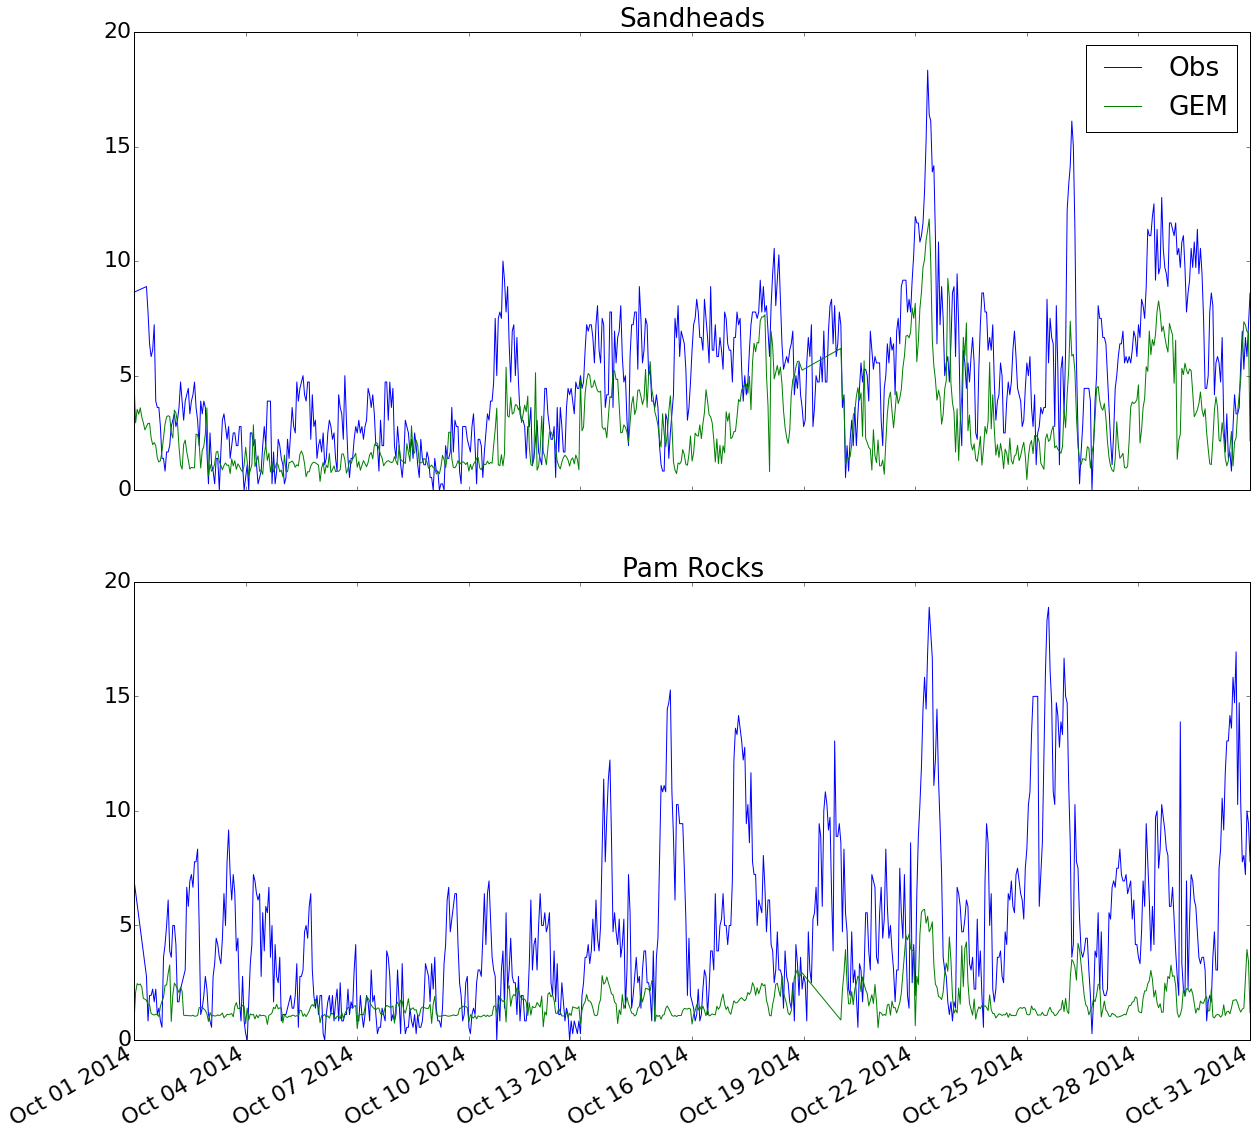

In [45]:
fig1 = plt.figure(figsize=(20,20))
mpl.rcParams.update({'font.size': 22})
ax1 = fig1.add_subplot(211)
ax1.plot(time['Sandheads'], wind_speed['Sandheads'])
ax1.plot(time['Sandheads_GEM'], wind_speed['Sandheads_GEM'])
plt.xlim('2014-10-1', '2014-10-31')
plt.title('Sandheads')
ax1.legend({'Obs', 'GEM'})
ax2 = fig1.add_subplot(212)
ax2.plot(time['PamRocks'], wind_speed['PamRocks'])
ax2.plot(time['PamRocks_GEM'], wind_speed['PamRocks_GEM'])
plt.xlim('2014-10-1', '2014-10-31')
plt.title('Pam Rocks')
fig1.autofmt_xdate()

plt.savefig('/ocean/bmoorema/research/figures/windcomparison.eps')